## Query Transformations:
Query transformation in RAG (Retrieval-Augmented Generation) is the process of modifying or refining the input query to optimize the retrieval of relevant information from external knowledge sources. This ensures that the retriever fetches the most pertinent data for the generative model to process.

These approaches are focused on re-writing the queries or generating similar quesries for better retrieval. These approches are helpful when input query is too small or poorly written. 

In [16]:
!pip install --upgrade openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 9.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: openai
    Found existing installation: openai 0.28.0
    Uninstalling openai-0.28.0:
      Successfully uninstalled openai-0.28.0

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'True'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = [Your LangChain API]
LANGCHAIN_PROJECT="RAG_basics"

os.environ['OPENAI_API_KEY'] = [Your OpenAi API]

In [3]:
import openai
openai.api_key = [Your OpenAi API]

### First Approach: Multi Query

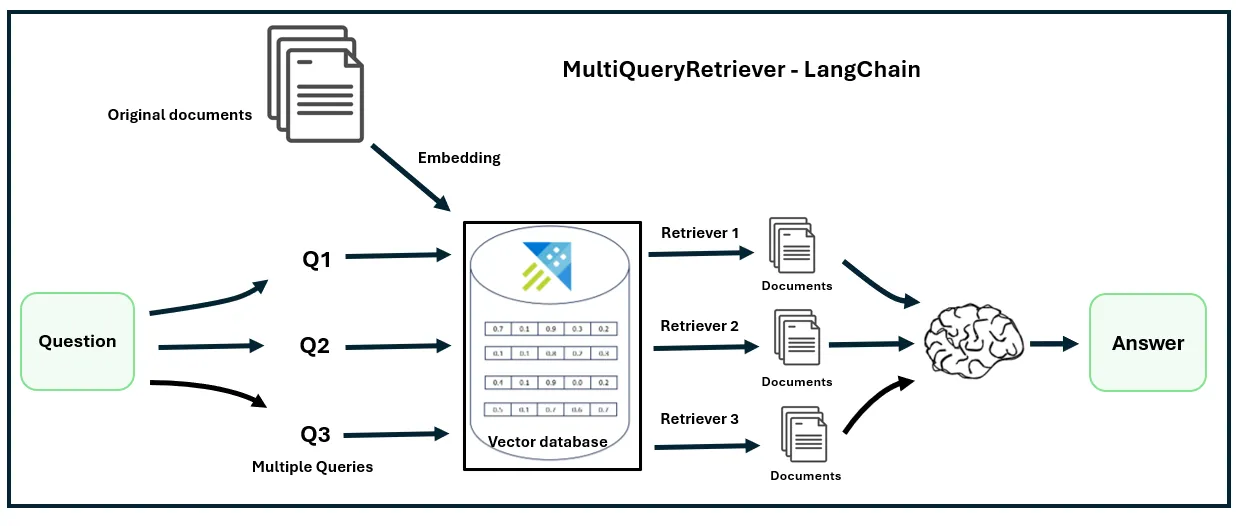

#### INDEXING

In [4]:
#### INDEXING ####
# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Index
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

# # Chroma Vectorstore
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.
/var/folders/ll/hqtjh2m5481_qkt_4p9g5v940000gn/T/ipykernel_45237/753231905.py:30: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding=OpenAIEmbeddings())


In [5]:
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x10edce110>, search_kwargs={})

### Prompt

This is the prompt which we are using to generate the multiple queries for the single query.

In [6]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [7]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"

# Chaining the process
retrieval_chain = generate_queries | retriever.map() | get_unique_union
# Retrieve documnets from multiple queries
docs = retrieval_chain.invoke({"question":question})
len(docs)

/var/folders/ll/hqtjh2m5481_qkt_4p9g5v940000gn/T/ipykernel_45237/2784938305.py:10: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  return [loads(doc) for doc in unique_docs]


5

In [9]:
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

Here we will provide the reterieved docs as a context for the query

In [8]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals. This enables efficient handling of complex tasks by the agent. The agent can utilize techniques like Chain of Thought and Tree of Thoughts to decompose hard tasks into smaller and simpler steps, allowing for a more structured approach to problem-solving. Task decomposition can be done through simple prompting, task-specific instructions, or with human inputs.'

### Second Approach: RAG-Fusion
RAG (Retrieval-Augmented Generation) fusion is a method that combines retrieving relevant external information with generating responses, enabling AI to provide accurate and up-to-date answers by fusing retrieved data with its knowledge.

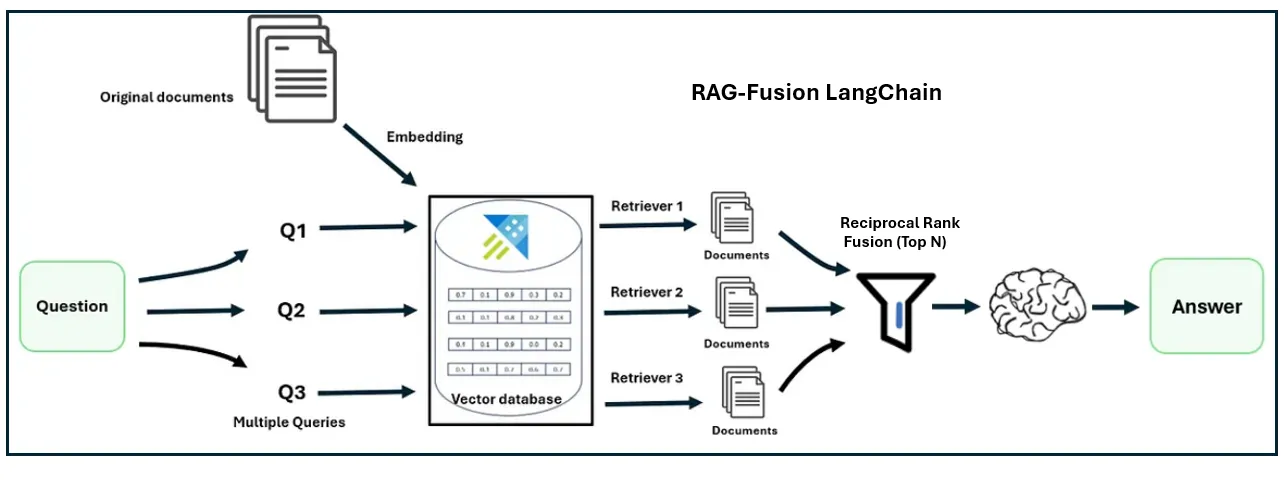

In [11]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [13]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

7

In [14]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals. This process enables the agent to efficiently handle complex tasks by dividing them into smaller and simpler steps. Task decomposition can be achieved through techniques like Chain of Thought (CoT) and Tree of Thoughts, which help the model decompose hard tasks into smaller and simpler steps, making them more manageable. Additionally, task decomposition can be done through simple prompting, task-specific instructions, or with human inputs.'

### Third Approach: Step-Back

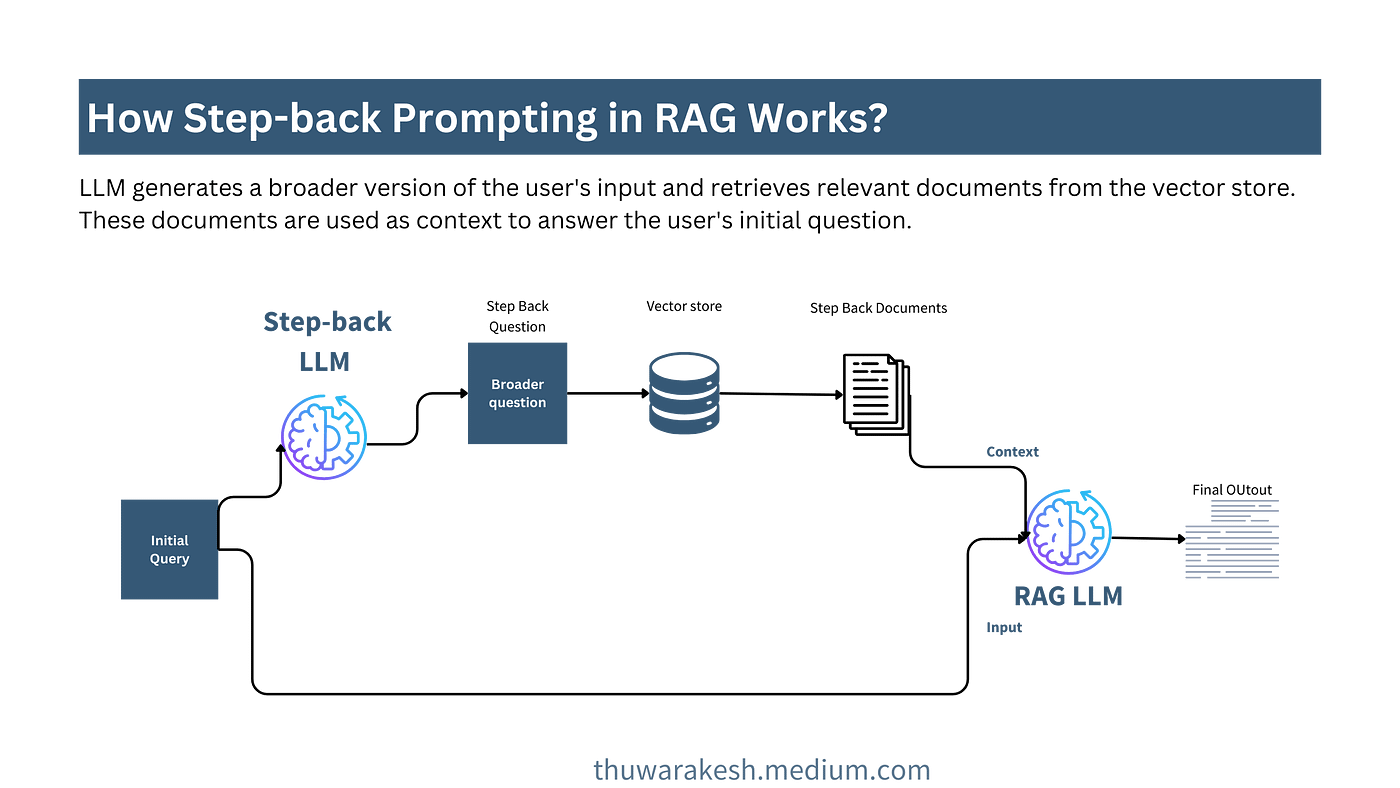

#### Step-back LLM prompt

In [15]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

#### Setting up the chain

In [16]:
generate_queries_step_back = prompt | ChatOpenAI(temperature=0) | StrOutputParser()
question = "What is task decomposition for LLM agents?"
generate_queries_step_back.invoke({"question": question})


'What is the process of breaking down tasks for LLM agents?'

In [18]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser

# Response prompt 
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
)

chain.invoke({"question": question})

'Task decomposition for LLM agents refers to the process of breaking down complex tasks into smaller, more manageable subgoals or steps. This allows the LLM-powered autonomous agent to efficiently handle intricate tasks by dividing them into simpler components. Task decomposition is essential for planning and executing tasks effectively, as it enables the agent to navigate through the various steps required to accomplish a larger goal.\n\nIn the context of LLM agents, task decomposition can be achieved through various techniques such as Chain of Thought (CoT) and Tree of Thoughts. CoT prompts the model to "think step by step," utilizing more computation to break down hard tasks into smaller steps. This technique transforms big tasks into multiple manageable tasks and provides insights into the model\'s thinking process. On the other hand, Tree of Thoughts extends CoT by exploring multiple reasoning possibilities at each step, creating a tree structure of thought steps and generating mu

### Fourth Approach: HyDE (Hypothetical Document Embeddings)
Paper Link: https://arxiv.org/abs/2212.10496
Referance: https://medium.aiplanet.com/advanced-rag-improving-retrieval-using-hypothetical-document-embeddings-hyde-1421a8ec075a
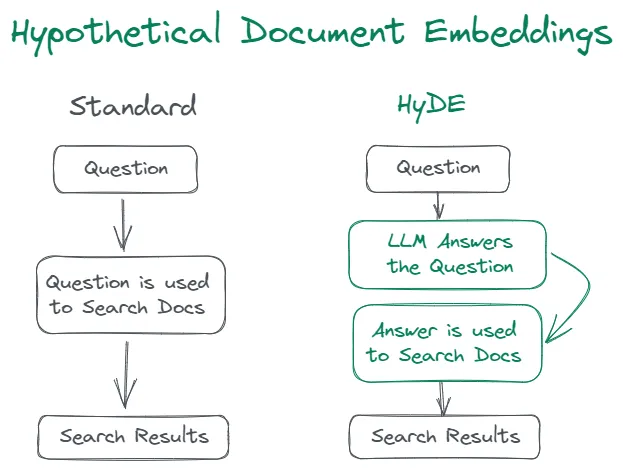

In [19]:
from langchain.prompts import ChatPromptTemplate

# HyDE document genration
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_docs_for_retrieval = (
    prompt_hyde | ChatOpenAI(temperature=0) | StrOutputParser() 
)

# Run
question = "What is task decomposition for LLM agents?"
generate_docs_for_retrieval.invoke({"question":question})

'Task decomposition is a fundamental concept in the field of reinforcement learning and artificial intelligence, particularly for Large Language Models (LLMs) agents. Task decomposition refers to the process of breaking down a complex task into smaller, more manageable sub-tasks or components. This allows the agent to effectively tackle the overall task by focusing on individual components sequentially or in parallel.\n\nIn the context of LLM agents, task decomposition is crucial for improving the efficiency and effectiveness of the learning process. By breaking down a complex task into smaller sub-tasks, LLM agents can better understand the underlying structure and dependencies within the task. This enables the agent to learn more efficiently and make better decisions when faced with similar tasks in the future.\n\nFurthermore, task decomposition can also help LLM agents generalize their learning to new and unseen tasks. By decomposing tasks into smaller components, the agent can iden

In [20]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever 
retireved_docs = retrieval_chain.invoke({"question":question})
retireved_docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search

In [21]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":retireved_docs,"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller and more manageable subgoals. This allows the agent to efficiently handle complex tasks by dividing them into smaller steps that can be tackled individually. Task decomposition can be achieved through techniques like Chain of Thought and Tree of Thoughts, which prompt the model to think step by step and explore multiple reasoning possibilities at each step. Additionally, task decomposition can be done through simple prompting, task-specific instructions, or with human inputs.'